In [8]:
from torchvision.datasets.utils import download_url
import json
# Download class labels from imagenet dataset
download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

Using downloaded and verified file: ./imagenet_class_index.json


In [9]:
import torch
import torch.nn as nn

from torch.utils import data
from torchvision.models import vgg16
from torchvision.models import resnet50
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets.utils import download_url
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder(root='./data/', transform=transform)

dataloader = data.DataLoader(dataset=dataset, shuffle=False )#batch_size=1

# initialize the model
model = resnet50(pretrained=True)
#vgg = vgg16(pretrained=True)

In [10]:
# set the evaluation mode
model.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

In [11]:
# get the most likely prediction of the model
pred = model(img)#.argmax(dim=1)
pred_sorted = torch.sort(pred, descending=False)

#print(pred_sorted[0])
#sorted_pred = np.argsort(np.array(pred))


In [12]:
print(pred.argmax(dim=1))
with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

print(labels['2'])

tensor([2])
['n01484850', 'great_white_shark']


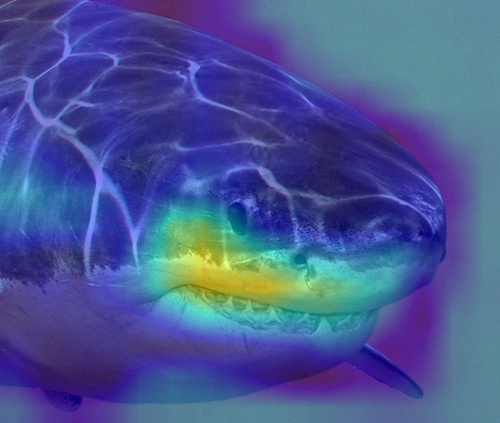

In [32]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img = np.asarray(cv2.imread('./data/Shark/shark.jpg'))

img = np.squeeze(img)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = np.float32(img)/255
input_tensor = preprocess_image(img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
target_layers = [model.layer4[-1]]
#input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#if torch.cuda.is_available():
 #   input_batch = input_batch.to('cuda')
  #  vgg.to('cuda')

#input_tensor = input_tensor.unsqueeze(0)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False) # use_cuda=args.use_cuda
#targets = [ClassifierOutputTarget(281)]
grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True )[0, :]
#grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, colormap = cv2.COLORMAP_JET) #
#plt.imshow(img)
Image.fromarray(visualization)

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # pretrained VGG network
        self.vgg = vgg16(pretrained=True)

        # access its last convolutional layer
        self.features_conv = self.vgg.features[:-1]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

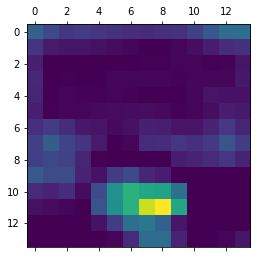

In [35]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 2].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [36]:
import cv2
img = np.asarray(cv2.imread('./data/Shark/sealions_on_the_beach.jpg'))
dsize = (img.shape[1], img.shape[0])
heatmap_arr = np.asarray(heatmap)
heatmap = cv2.resize(heatmap_arr, dsize)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)
#img2 = superimposed_img[:,:,::-1]
#plt.imshow(img2)

True